In [1]:
# loading
from sensorFusionDataset.creatDataset import CreateDatasets
import glob
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader
from sensorFusionDataset.creatDataset import CreateDatasets
from sensorFusionNetwork.simpleAutoencoder import SimpleAutoencoder
import numpy as np
import torch
import torch.nn as nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
dataset_path = 'testdataset/damaged_image'
noi_img_list = sorted(glob.glob(dataset_path + '/*'))
ori_img_path = 'testdataset/ori_image'
img_list = sorted(glob.glob(ori_img_path + '/*'))

batch_size = 32

TestDataset = CreateDatasets(img_list, noi_img_list)
new_testloader = DataLoader(dataset=TestDataset, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

test_model_best = SimpleAutoencoder()
test_model_best.load_state_dict(
    torch.load('model_save/ori2ori/ori2ori_best_model_600_32_20230518_044338.pth')
)

<All keys matched successfully>

In [8]:
# use ori2ori encoder-decoder to see denoising effect
# visualization

# test_model_best.eval()

# obtain one batch of test images
dataiter = iter(new_testloader)
ori_img, noi_img = next(dataiter)
ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)
# ori_img, noi_img = next(dataiter)

# get sample outputs
output = test_model_best(noi_img)


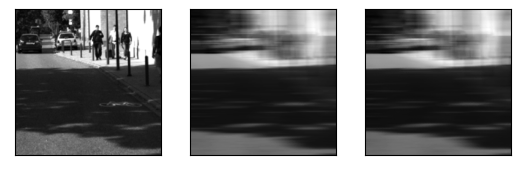

In [9]:

# prep images for display
for i in range(batch_size):

    img1 = ori_img[i].numpy()
    img1 = img1.transpose(1, 2, 0)
    img2 = noi_img[i].numpy()
    img2 = img2.transpose(1, 2, 0)
    img3 = output[i].detach().numpy()
    img3 = img3.transpose(1, 2, 0)

    
    ax = plt.subplot(1, 3, 1)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('original image')
    plt.imshow(img1,cmap='gray')

    ax = plt.subplot(1, 3, 2)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('noisy image')
    plt.imshow(img2,cmap='gray')

    ax = plt.subplot(1, 3, 3)
    plt.xticks([])
    plt.yticks([])
    # ax.set_title('denoised image')
    plt.imshow(img3,cmap='gray')

    plt.savefig('fig_save/denoising_{}.png'.format(i))
plt.show()




In [5]:
dataiter = iter(new_testloader)
num_iterations = 10  # Change this to the desired number of iterations

criterion = nn.MSELoss()
criterion.to(device)

for i in range(num_iterations):
    label, damaged_img = next(dataiter)
    output = test_model_best(damaged_img)


    batch_size = 32
    count = 0

    for j in range (batch_size):
        img1 = label[j]
        img3 = output[j]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)

3.473
0.42
3.491
2.299
4.428
3.072
0.081
0.493
0.105
0.259


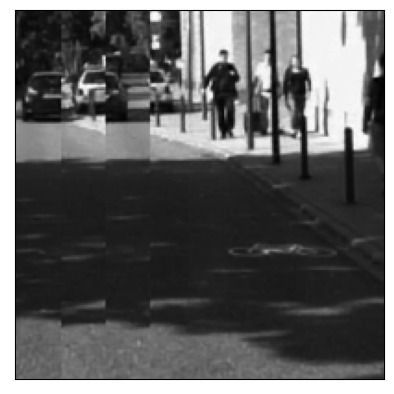

In [5]:
import cv2
from torchvision import transforms


dataiter = iter(new_testloader)
num_iterations = 10 

for j in range(num_iterations):
    label, damaged_img = next(dataiter)
    output = test_model_best(damaged_img)

    for i in range(32):
        img1 = label[i]
        img4 = output[i].detach().numpy()
        img4 = img4.transpose(1, 2, 0)
        name = '%02d' %i

        plt.xticks([])
        plt.yticks([])
        plt.imshow(img4, cmap='gray')
        # plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
        # plt.margins(0,0)

        plt.savefig('fig_save/baseline/{}_{:02}.png'.format(j,i),bbox_inches = 'tight',transparent = True)

In [4]:
# MSE for all damages
criterion = nn.MSELoss()
criterion.to(device)


for i, batch in enumerate(new_testloader):# i -->index of batch
    count = 0
    for j in range (batch_size):
        img1 = ori_img[i]
        img3 = output[i]
        mse = criterion(img1,img3)
        mse = round(mse.item(),6)
        count = count+mse

    mse_mean = round(count,3)
    print(mse_mean)
    

NameError: name 'ori_img' is not defined

In [27]:
# regional mse

batch_size = 32

def create_mask(image_shape, block_size, num_blocks):
    mask = np.ones(image_shape, dtype=np.float32) 
    block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
    np.random.seed(6)

    for _ in range(num_blocks):
        top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
        bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
        mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        
    return mask


block_size = 0.2  # 方块大小为原图大小的百分比
num_blocks = 16  # 方块数量

count = 0

for j in range(ori_img.size(0)):
    ori_img_np = ori_img[j][0].detach().numpy()
    output_np = output[j][0].detach().numpy()
    mask = create_mask(ori_img_np.shape[:2], block_size, num_blocks)
    local_mse = np.mean(np.square(output_np - ori_img_np) * mask)
    count = count+local_mse
local_mse = round(count,6)

print(local_mse)

0.00727


In [33]:
import numpy as np
batchsize = 32
def mse(image1, image2, mask):
    masked_image1 = image1 * mask
    masked_image2 = image2 * mask
    diff = masked_image1 - masked_image2
    mse_value = np.mean(np.square(diff))
    return mse_value

def create_mask(image_shape, block_size, num_blocks):
    mask = np.ones(image_shape, dtype=np.float32) 
    block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
    np.random.seed(6)

    for _ in range(num_blocks):
        top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
        bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
        mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
    return mask

count = 0
shape = (200, 200)
block_size = 0.2
num_blocks =16
mask = create_mask(shape, block_size, num_blocks)

for j in range(batchsize):
    original_image = ori_img[j][0].detach().numpy()
    output_image = output[j][0].detach().numpy()
    mask_mse = mse(output_image, original_image, mask)
    count += mask_mse
     
print(count/batchsize)
# 0.11023531737737358


0.00022718461684689828


In [38]:
masked_region_list = []
original_image_list = []

image_path = 'testdataset/ori_image'
images = sorted(glob.glob(image_path + '/*'))[0:32]
damage_label = 'A'

def create_mask(image_shape, block_size, num_blocks):
    mask = np.ones(image_shape, dtype=np.float32) 
    block_size_px = (int(image_shape[0] * block_size), int(image_shape[1] * block_size))
    np.random.seed(6)
    masked_region = []

    for _ in range(num_blocks):
        top_left = np.random.randint(0, image_shape[0] - block_size_px[0] + 1), np.random.randint(0, image_shape[1] - block_size_px[1] + 1)
        bottom_right = top_left[0] + block_size_px[0], top_left[1] + block_size_px[1]
        mask[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]] = 0
        masked_region.append((top_left, bottom_right))
        
    return mask, masked_region


for i in range(len(images)):
    image = cv2.imread(images[i])
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ori_img_name = os.path.basename(images[i])

    block_size = 0.2  # 方块大小为原图大小的百分比
    num_blocks = 16  # 方块数量
    mask, masked_region = create_mask(image.shape[:2], block_size, num_blocks)
    masked_region_list.append(masked_region)
    original_image_list.append(image)
    damaged_img1 = image * mask
    # cv2.imwrite(f'testdataset/damaged_image/{damage_label}_{ori_img_name}', damaged_img1)

regional_mse_list = []

for i in range(len(images)):
    original_image = original_image_list[i]
    masked_region = masked_region_list[i]

    # Obtain the output reconstructed image
    output_image = output[j][0].detach().numpy()  # Replace this with the code to get the output image from your image reconstruction network

    mse = 0
    num_pixels = 0

    for region in masked_region:
        top_left, bottom_right = region
        original_pixels = original_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        output_pixels = output_image[top_left[0]:bottom_right[0], top_left[1]:bottom_right[1]]
        diff = original_pixels.astype(np.float32) - output_pixels.astype(np.float32)
        mse += np.sum(diff ** 2)
        num_pixels += original_pixels.size

    mse /= num_pixels
    regional_mse_list.append(mse)

print(np.mean(regional_mse_list))

16380.458031806946


In [8]:
# LLIPS metrics

import lpips

loss_fn = lpips.LPIPS(net='alex')


for i, batch in enumerate(new_testloader):  # i -->index of batch
    ori_img, noi_img = batch
    test_model_best.eval()
    output = test_model_best(noi_img)
    count = 0
    for j in range(ori_img.size(0)):
        # ori_img_np = ori_img[j][0].detach().numpy()
        # output_np = output[j][0].detach().numpy()
        lpips_img = loss_fn.forward(ori_img, output)
        sum_result = (torch.sum(lpips_img)).item()
        count = count+sum_result
        # count = count.item()
    lpips_img = round(count/ori_img.size(0),3)
    print(lpips_img)
#     metric_value_list.append(lpips_img)

# print(f'scuccess: {metric_value_list}')



    

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/Anaconda3-2021.11-Linux-x86_64/envs/pytorch/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


KeyboardInterrupt: 

In [7]:
# SSIM

import torch
from skimage.metrics import structural_similarity as ssim
import glob


metric_value_list = []
batch_size = 32


for i, batch in enumerate(new_testloader):
    ori_img, noi_img = batch
    test_model_best.eval()
    output = test_model_best(noi_img)
    count = 0
    for j in range(ori_img.size(0)):
        ori_img_np = ori_img[j][0].detach().cpu().numpy()
        output_np = output[j][0].detach().cpu().numpy()
        ssim_img, diff = ssim(ori_img_np, output_np, full=True, data_range=1.0)
        count = count + ssim_img
    ssim_img = round(count / ori_img.size(0), 3)
    print(ssim_img)
#     metric_value_list.append(ssim_img)

# print(metric_value_list)

0.448
0.574
0.664
0.493
0.446
0.239
0.827
0.596
